In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import cv2

In [2]:
c = 0.5
epsilon0 = 1.0
mu_0 = 1.0 / (epsilon0 * c**2)
m_unit = 1.0
r_m = 1/9
m_electron = 1 * m_unit
m_ion = m_electron / r_m
t_r = 1.0/1.0
r_q = 1.0
n_e = 10 #ここは手動で調整すること
B0 = np.sqrt(n_e) / 1 / np.sqrt(2/(1+t_r))
n_i = int(n_e / r_q)
T_i  = (B0**2 / 2.0 / mu_0) / (n_i + n_e * t_r)
T_e = T_i * t_r
debye_length = 1.0
q_unit = np.sqrt(epsilon0 * T_e / n_e) / debye_length
q_electron = -1 * q_unit
q_ion = r_q * q_unit
debye_length = np.sqrt(epsilon0 * T_e / n_e / q_electron**2)
omega_pe = np.sqrt(n_e * q_electron**2 / m_electron / epsilon0)
omega_pi = np.sqrt(n_i * q_ion**2 / m_ion / epsilon0)
omega_ce = q_electron * B0 / m_electron
omega_ci = q_ion * B0 / m_ion
ion_inertial_length = c / omega_pi
sheat_thickness = 1.0 * ion_inertial_length
v_electron = np.array([0.0, 0.0, c * debye_length / sheat_thickness * np.sqrt(2 / (1.0 + 1/t_r))])
v_ion = -v_electron / t_r
v_thermal_electron = np.sqrt(2.0 * T_e / m_electron)
v_thermal_ion = np.sqrt(2.0 * T_i / m_ion)
V_Ai = B0 / np.sqrt(mu_0 * n_i * m_ion)
V_Ae = B0 / np.sqrt(mu_0 * n_e * m_electron)
beta_e = n_e * T_e / (B0**2 / 2 / mu_0)
beta_i = n_i * T_i / (B0**2 / 2 / mu_0)

dx = 1.0
dy = 1.0
n_x = int(ion_inertial_length * 300)
n_y = int(ion_inertial_length * 75)
x_min = 0.0 * dx
y_min = 0.0 * dy
x_max = n_x * dx
y_max = n_y * dy
x_coordinate = np.arange(0.0, x_max, dx)
y_coordinate = np.arange(0.0, y_max, dy)
dt = 0.5
step = 20000
t_max = step * dt

n_ion = int(n_x * n_i * 2.0 * sheat_thickness)
n_electron = int(n_ion * abs(q_ion / q_electron))
n_ion_background = int(n_x * n_y * 0.4 * n_i)
n_electron_background = int(n_x * n_y * 0.4 * n_e)
n_particle = n_ion + n_ion_background + n_electron + n_electron_background
print(f"total number of particles is {n_particle}.")
print(f"omega_pe = {omega_pe}, omega_ce = {omega_ce}")
print(f"total time step of 1000/Omega_ci = {int(1000 / omega_ci/dt)} (10/Omega_ci = {int(10/omega_ci/dt)})")

total number of particles is 6912000.
omega_pe = 0.25, omega_ce = -0.25
total time step of 1000/Omega_ci = 72000 (10/Omega_ci = 720)


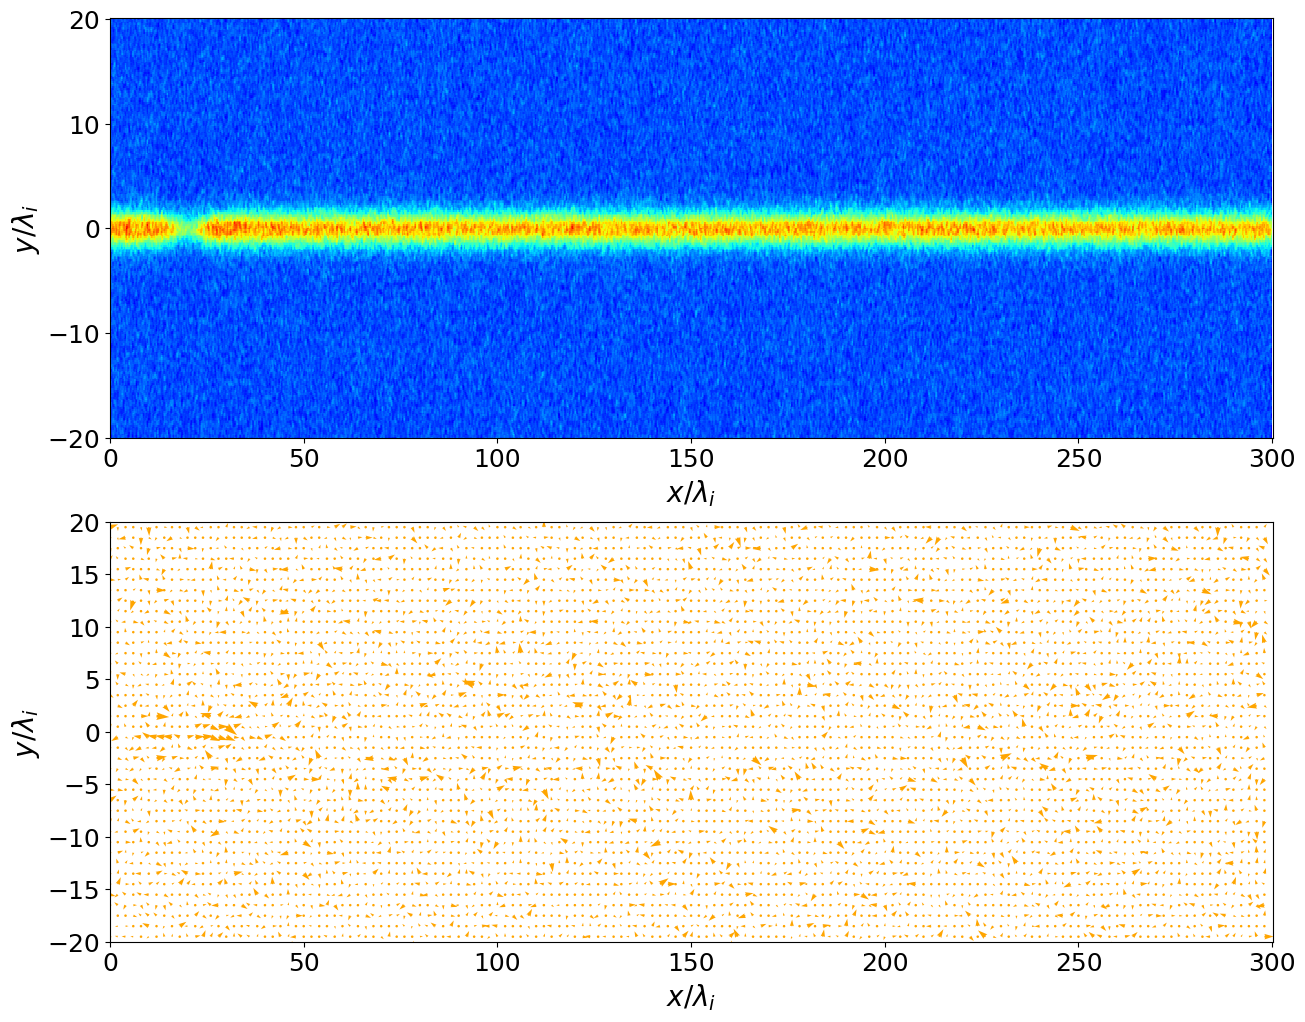

In [3]:
dirname = "results_mr=200-9_n=2"
file_num = 2000
zeroth_moment_ion = np.loadtxt(f'{dirname}/mr2008_zeroth_moment_ion_{file_num}.txt', delimiter=',').reshape(n_x, n_y)
first_moment_ion = np.loadtxt(f'{dirname}/mr2008_first_moment_electron_{file_num}.txt', delimiter=',').reshape(3, n_x, n_y)
B = np.loadtxt(f'{dirname}/mr2008_B_{file_num}.txt', delimiter=',').reshape(3, n_x, n_y)
bulk_ion = first_moment_ion / (zeroth_moment_ion + 1e-10)

start_y = np.arange(0, 15, 0.5)
start_points = np.array([np.zeros(start_y.shape)+x_max/ion_inertial_length-1, start_y])


fig = plt.figure(figsize=(15, 12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

X, Y = np.meshgrid(x_coordinate, y_coordinate - y_max/2) / ion_inertial_length

mappable = ax1.pcolormesh(X, Y, cv2.blur(zeroth_moment_ion.T/n_i, (3, 3)), cmap='jet', vmin=0, vmax=2)
#ax1.streamplot(X, Y, B[0, :, :].T, B[1, :, :].T, broken_streamlines=False, 
#                  start_points=start_points.T, color='white', density = 100, linewidth=2, arrowsize=0)
ax1.set_xlabel('$x / \lambda_i$', fontsize=20)
ax1.set_ylabel('$y / \lambda_i$', fontsize=20)
ax1.set_xlim(0.0, x_max/ion_inertial_length+0.1)
ax1.set_ylim(-20.0, 20.0+0.1)
ax1.tick_params(labelsize=18)

nx_quiver = 300
ny_quiver = 75
X, Y = np.meshgrid(np.arange(nx_quiver), np.arange(ny_quiver))
index1 = 2

number_density_ion = np.zeros([nx_quiver, ny_quiver])
velocity_average_ion = np.zeros([3, nx_quiver, ny_quiver]) * np.nan
for i in range(int(nx_quiver / index1)):
    for j in range(ny_quiver):
        xmin = int(index1*i*ion_inertial_length)
        xmax = int(index1*(i+1)*ion_inertial_length)
        ymin = int(j*ion_inertial_length)
        ymax = int((j+1)*ion_inertial_length)
        number_density_ion[index1*i, j] = np.mean(zeroth_moment_ion[xmin:xmax, ymin:ymax]) 
        velocity_average_ion[0, index1*i, j] = np.mean(first_moment_ion[0, xmin:xmax, ymin:ymax]) / (number_density_ion[index1*i, j] + 1e-10)
        velocity_average_ion[1, index1*i, j] = np.mean(first_moment_ion[1, xmin:xmax, ymin:ymax]) / (number_density_ion[index1*i, j] + 1e-10)
        velocity_average_ion[2, index1*i, j] = np.mean(first_moment_ion[2, xmin:xmax, ymin:ymax]) / (number_density_ion[index1*i, j] + 1e-10)
        
ax2.quiver(X, Y-ny_quiver/2, velocity_average_ion[0].T/c, velocity_average_ion[1].T/c, scale=10, color='orange')
ax2.set_xlabel('$x / \lambda_i$', fontsize=20)
ax2.set_ylabel('$y / \lambda_i$', fontsize=20)
ax2.set_xlim(0, x_max/ion_inertial_length+0.1)
ax2.set_ylim(-20, 20)
ax2.tick_params(labelsize=18)

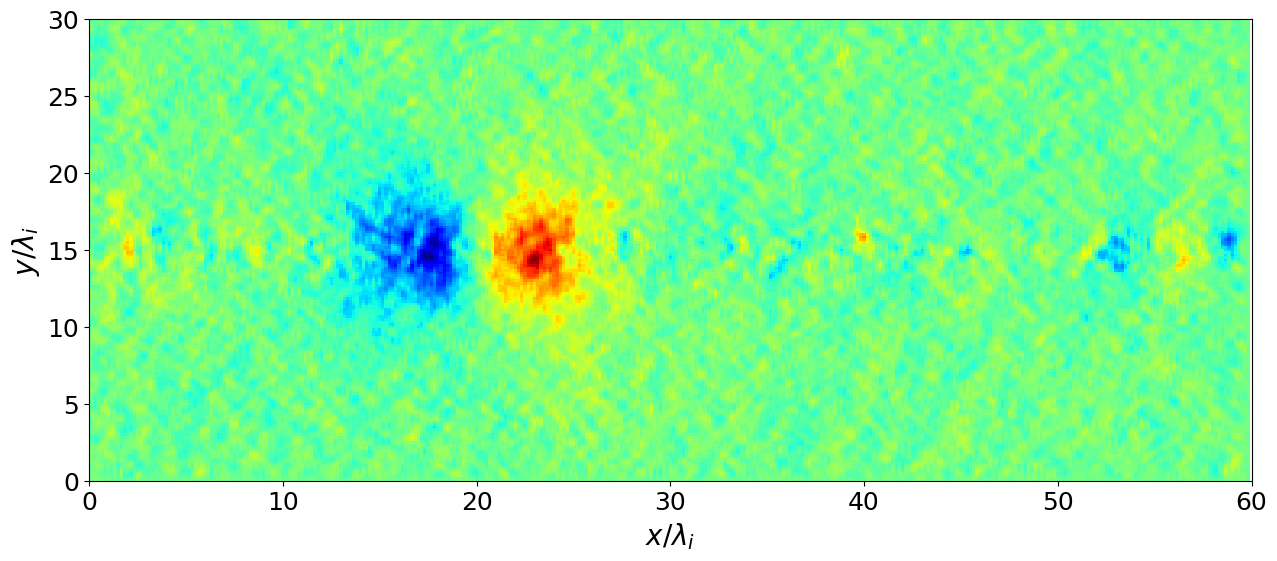

In [188]:
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(111)

file_num = 1000
X, Y = np.meshgrid(x_coordinate, y_coordinate) / ion_inertial_length
B = np.loadtxt(f'results/mr2008_B_{file_num}.txt', delimiter=',').reshape(3, n_x, n_y)
mappable = ax.pcolormesh(X, Y, cv2.blur(B[1, :, :].T/B0, (3, 3)), cmap='jet')
ax.set_xlabel('$x / \lambda_i$', fontsize=20)
ax.set_ylabel('$y / \lambda_i$', fontsize=20)
ax.set_xlim(0.0, x_max/ion_inertial_length)
ax.set_ylim(0.0, y_max/ion_inertial_length)
ax.tick_params(labelsize=18)

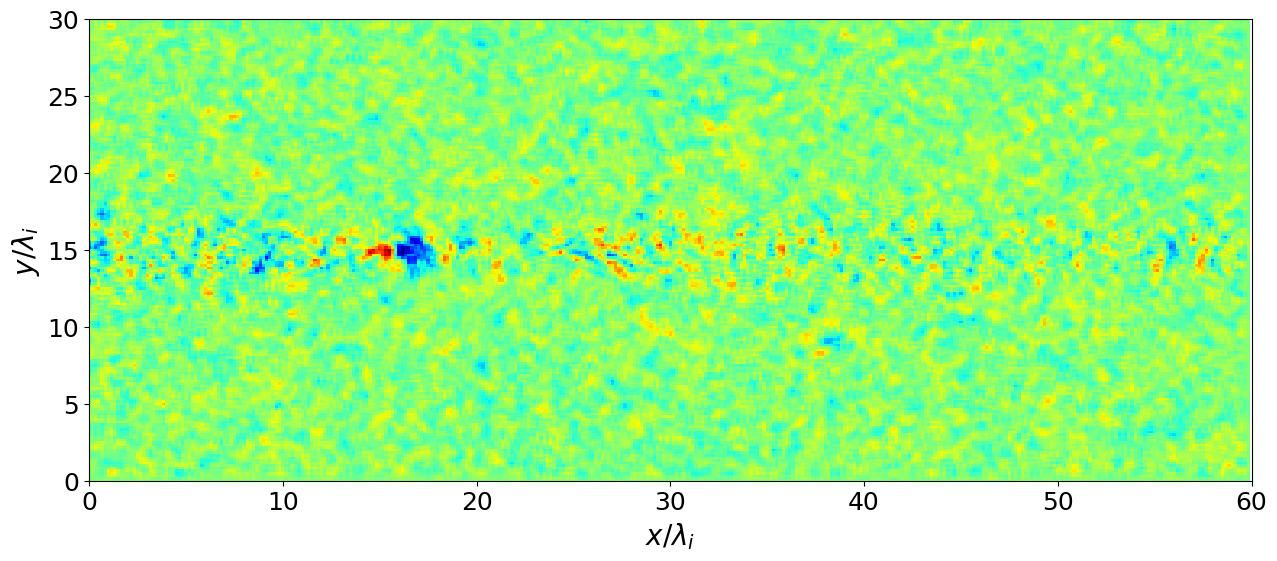

In [194]:
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(111)

file_num = 2000
X, Y = np.meshgrid(x_coordinate, y_coordinate) / ion_inertial_length
E = np.loadtxt(f'results/mr2008_E_{file_num}.txt', delimiter=',').reshape(3, n_x, n_y)
mappable = ax.pcolormesh(X, Y, cv2.blur(E[0, :, :].T, (3, 3)), cmap='jet')
ax.set_xlabel('$x / \lambda_i$', fontsize=20)
ax.set_ylabel('$y / \lambda_i$', fontsize=20)
ax.set_xlim(0.0, x_max/ion_inertial_length)
ax.set_ylim(0.0, y_max/ion_inertial_length)
ax.tick_params(labelsize=18)

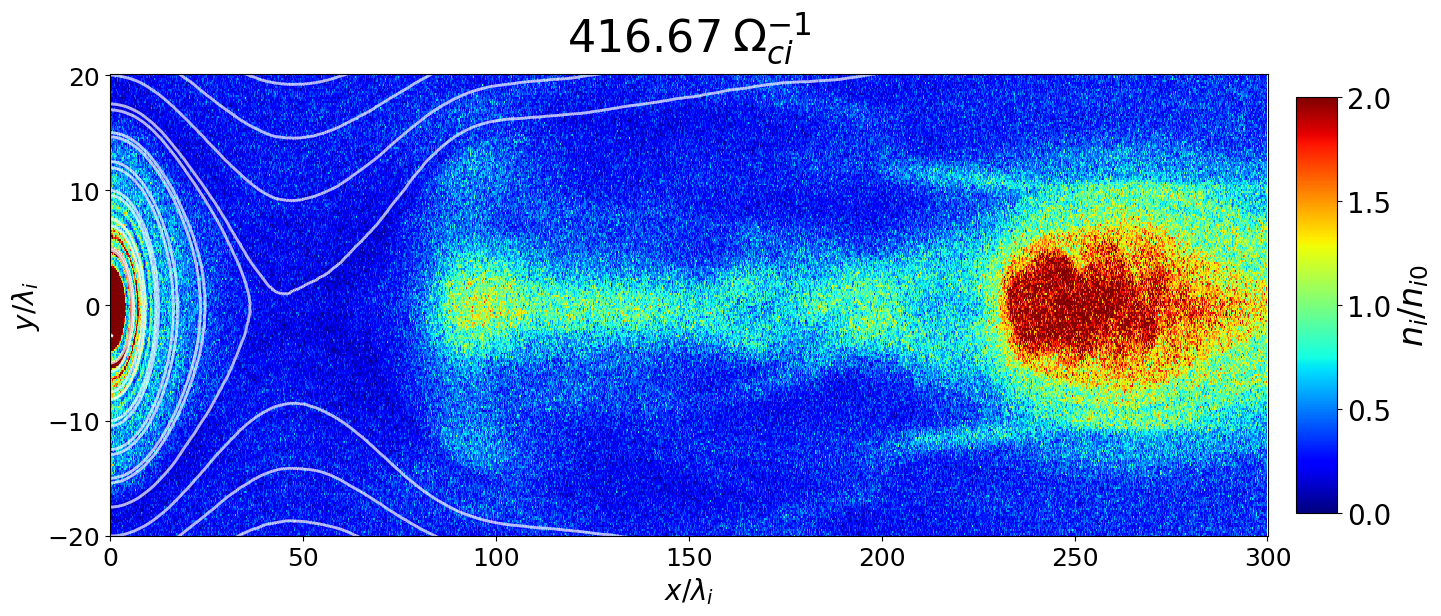

In [7]:
fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_subplot(111)

interval = 100
total_steps = 30000
dirname = "results_mr=200-9_n=2"

X, Y = np.meshgrid(x_coordinate, y_coordinate - y_max/2) / ion_inertial_length
start_y_enlarged = np.arange(-y_max/2/ion_inertial_length+5, y_max/2/ion_inertial_length-5+0.1, 2.5)
start_points_enlarged = np.array([np.zeros(start_y_enlarged.shape), start_y_enlarged])
start_y = np.arange(-y_max/2/ion_inertial_length, y_max/2/ion_inertial_length, 5)
start_points = np.array([np.zeros(start_y.shape), start_y])

for step in range(0, total_steps+1, interval):
    ax1.clear()

    zeroth_moment_ion = np.loadtxt(f'{dirname}/mr2008_zeroth_moment_ion_{step}.txt', delimiter=',').reshape(n_x, n_y)
    B = np.loadtxt(f'{dirname}/mr2008_B_{step}.txt', delimiter=',').reshape(3, n_x, n_y)

    if step == 0:
        mappable = ax1.pcolormesh(X, Y, zeroth_moment_ion.T / n_i, cmap='jet', vmin=0.0, vmax=2.0)
        cbar = fig.colorbar(mappable, ax=ax1, pad=0.02, shrink=0.9, aspect=10, ticks=np.arange(0.0, 2.1, 0.5))
        cbar.set_label(r'$n_i / n_{i0}$', fontsize=24)
        cbar.ax.tick_params(labelsize=20)
    else:
        ax1.pcolormesh(X, Y, zeroth_moment_ion.T / n_i, cmap='jet', vmin=0.0, vmax=2.0)

    ax1.streamplot(X, Y, B[0, :, :].T, B[1, :, :].T, broken_streamlines=False, 
                  start_points=start_points_enlarged.T, color='white', density = 100, linewidth=2, arrowsize=0)
    ax1.set_xlabel('$x / \lambda_i$', fontsize=20)
    ax1.set_ylabel('$y / \lambda_i$', fontsize=20)
    ax1.set_xlim(0.0, x_max/ion_inertial_length+0.1)
    ax1.set_ylim(-20.0, 20.0+0.1)
    ax1.tick_params(labelsize=18)
    ax1.set_yticks([-20.0, -10.0, 0.0, 10.0, 20.0])
    ax1.text(0.5, 1.05, f"{step * dt * omega_ci:.2f}" + r"$ \: \Omega_{ci}^{-1}$", ha='center', transform=ax1.transAxes, fontsize=32)

    fig.savefig(f'./pictures/{step}.png', dpi=200)
    

In [8]:
filename = "mr2008_triple_mr200_9.mp4"

img = cv2.imread(f'./pictures/0.png')
framesize = (img.shape[1], img.shape[0])
fps = 5.0

fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
video  = cv2.VideoWriter(filename=filename, fourcc=fourcc, fps=fps, frameSize=framesize)

for step in range(0, total_steps, interval):
    img = cv2.imread(f'./pictures/{step}.png')
    video.write(img)
video.release()

##################################################

In [31]:
number_of_results = 16
kinetic_energy = np.zeros(number_of_results)
electric_field_energy = np.zeros(number_of_results)
magnetic_field_energy = np.zeros(number_of_results)
t = np.arange(0, number_of_results*int(2/omega_ci/dt), int(2/omega_ci/dt))
dirname = "results"

for j in range(number_of_results):
        
    energy_E = np.loadtxt(f"{dirname}/mr2008_energy_E_{int(2/omega_ci/dt)*5*j}.csv")
    energy_B = np.loadtxt(f"{dirname}/mr2008_energy_B_{int(2/omega_ci/dt)*5*j}.csv")
    KE = np.loadtxt(f"{dirname}/mr2008_KE_{int(2/omega_ci/dt)*5*j}.csv")
    kinetic_energy[j] = KE
    electric_field_energy[j] = energy_E
    magnetic_field_energy[j] = energy_B
    print(f"{j} done...")

total_energy = kinetic_energy + electric_field_energy + magnetic_field_energy
print(total_energy[-1] / total_energy[0])

0 done...
1 done...
2 done...
3 done...
4 done...
5 done...
6 done...
7 done...
8 done...
9 done...
10 done...
11 done...
12 done...
13 done...
14 done...
15 done...
1.144533962494616


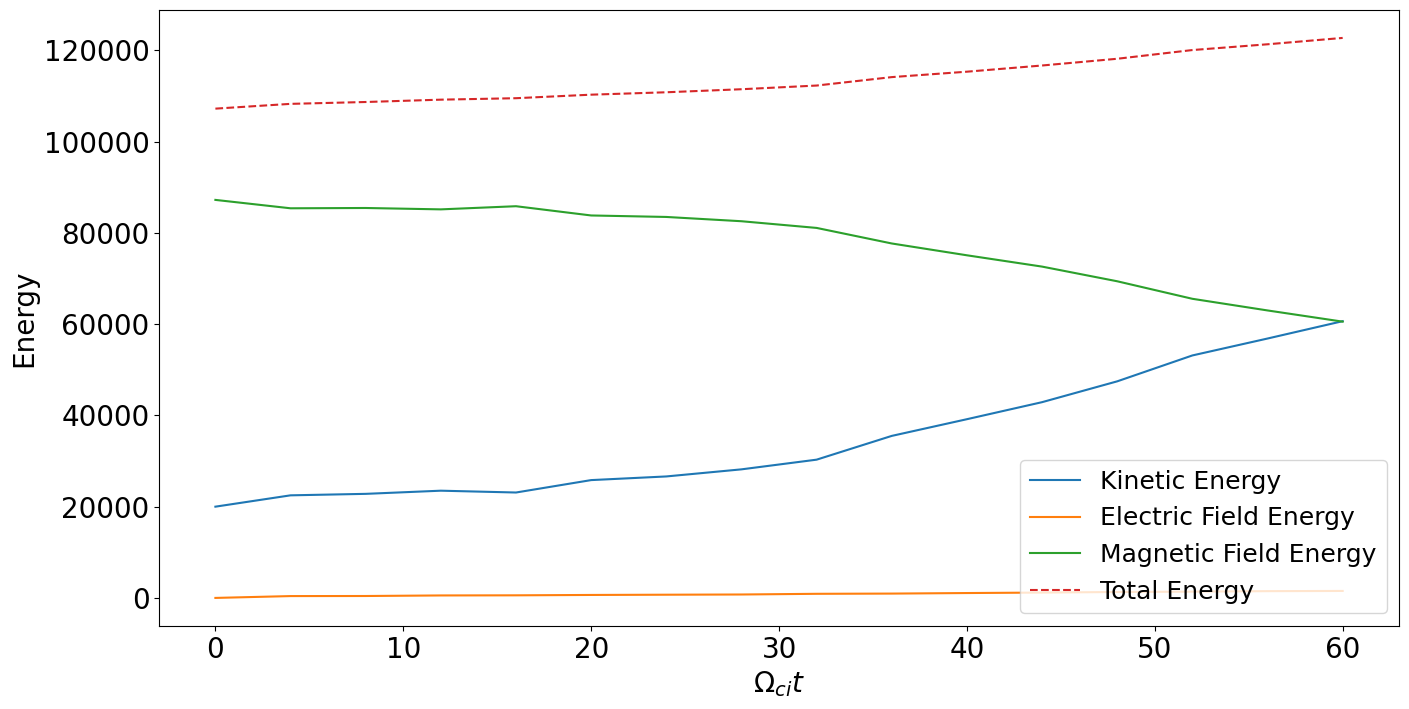

In [32]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
ax.plot(t*omega_ci, kinetic_energy, label='Kinetic Energy')
ax.plot(t*omega_ci, electric_field_energy, label='Electric Field Energy')
ax.plot(t*omega_ci, magnetic_field_energy, label='Magnetic Field Energy')
ax.plot(t*omega_ci, total_energy, label='Total Energy', ls='--')
ax.legend(loc='lower right', fontsize=18)
#ax.set_ylim(1e5)
#ax.set_xlim(0.0, number_of_results*5000*omega_ci)
ax.set_xlabel('$\Omega_{ci} t$', fontsize=20)
ax.set_ylabel('Energy', fontsize=20)
ax.tick_params(labelsize=20)
plt.show()
fig.savefig('test.png')

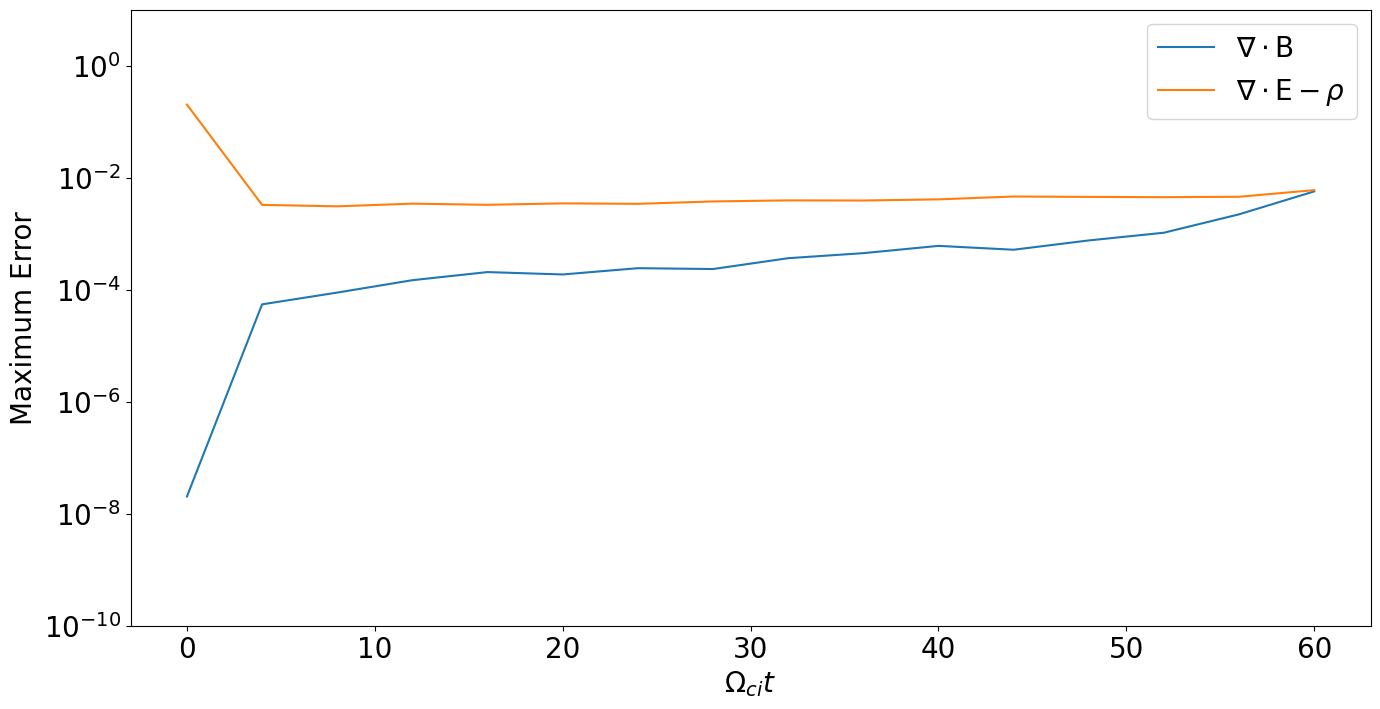

In [34]:
number_of_results = 16
div_B = np.zeros(number_of_results)
div_E = np.zeros(number_of_results)
t = np.arange(0, number_of_results*int(2/omega_ci/dt), int(2/omega_ci/dt))
dirname = "mr2008"

for j in range(number_of_results):  
    div_B[j] = np.loadtxt(f"{dirname}/mr2008_div_B_error_{int(2/omega_ci/dt)*5*j}.csv")
    div_E[j] = np.loadtxt(f"{dirname}/mr2008_div_E_error_{int(2/omega_ci/dt)*5*j}.csv")
    

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
ax.plot(t*omega_ci, div_B/n_x/n_y, label=r'$\nabla \cdot \mathrm{B}$')
ax.plot(t*omega_ci, div_E/n_x/n_y/q_unit, label=r'$\nabla \cdot \mathrm{E} - \rho$')
ax.set_ylim(1e-10, 1e1)
#ax.set_xlim(0.0, number_of_results*5000*omega_ci)
ax.set_xlabel('$\Omega_{ci} t$', fontsize=20)
ax.set_ylabel('Maximum Error', fontsize=20)
ax.tick_params(labelsize=20)
ax.set_yscale('log')
ax.legend(loc='upper right', fontsize=20)
fig.savefig("error2.png", dpi=200)